In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk
import torch_geometric
import json
from xml.dom import minidom
from tqdm import tqdm

from modeling import testModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\wangz\anaconda3\envs\sp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [2]:
from os import listdir
from os.path import isfile, join

mypath = "pants_straight_sides_1000"

onlyfiles_pants = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]

file_names_pants = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

mypath = "skirt_2_panels_1200"

onlyfiles_skirt = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]

file_names_skirt = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

In [6]:
def read_svg_string(svg_strings):
    edge_list = []
    edge_index = []
    ps = 0
    pe = 0

    panel_list = []

    for i in svg_strings:
        ps = pe
        tmp = i.split()
        prev_x = float(tmp[1])
        prev_y = float(tmp[2])
        j = 3
        while j < len(tmp):
            edge = [prev_x, prev_y]
            if tmp[j] == 'z':
                break

            if tmp[j] == 'L':
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                prev_x = float(tmp[j+1])
                prev_y = float(tmp[j+2])
                edge.append((edge[0] + edge[2]) / 2)
                edge.append((edge[1] + edge[3]) / 2)
                j = j + 3
                pe += 1
                edge_list.append(edge)
                continue
            if tmp[j] == 'Q':
                prev_x = float(tmp[j+3])
                prev_y = float(tmp[j+4])
                edge.append(float(tmp[j+3]))
                edge.append(float(tmp[j+4]))
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                j = j + 5
                pe += 1
                edge_list.append(edge)
                continue
        for j in range(ps, pe - 1):
            edge_index.append([j, j + 1])
        edge_index.append([pe - 1, ps])
        panel_list.append(pe - ps)

    edge_list = [convert_to_4(i) for i in edge_list]
    return [edge_list,edge_index, panel_list]
            


In [5]:
def convert_to_4(data):
    start_p = np.array([data[0], data[1]])
    end_p = np.array([data[2], data[3]])
    center_p = np.array([data[4], data[5]])

    line = end_p - start_p
    p_line = np.empty_like(line)
    p_line[0] = - line[1]
    p_line[1] = line[0]

    v = center_p - start_p
    cx = np.dot(line, v) / np.linalg.norm(line)
    cy = np.dot(p_line, v) / np.linalg.norm(p_line)

    return [line[0], line[1], cx, cy]

In [7]:
def get_data_from_spec(file_path):
    doc = minidom.parse(file_path)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    res = read_svg_string(path_strings)
    return res

In [34]:
data_pants = [get_data_from_spec(i) for i in onlyfiles_pants]
data_skirt = [get_data_from_spec(i) for i in onlyfiles_skirt]

train_data_pants = data_pants[100:]
test_data_pants = data_pants[:100]

train_data_skirt = data_skirt[100:]
test_data_skirt = data_skirt[:100]

train_data = train_data_pants + train_data_skirt
test_data = test_data_pants + test_data_skirt

In [35]:
tmp

[[[156.0, 0.0, 78.0, 33.534189172806066],
  [-3.0, -180.0, 90.01249913206499, 0.0],
  [-15.0, -45.0, 23.717082451262847, 0.0],
  [-120.0, 0.0, 60.0, -12.0],
  [-15.0, 45.0, 23.717082451262847, 0.0],
  [-3.0, 180.0, 90.01249913206499, 0.0],
  [156.0, 0.0, 78.0, -77.23003282365315],
  [-3.0, -180.0, 90.01249913206499, 0.0],
  [-15.0, -45.0, 23.717082451262847, 0.0],
  [-120.0, 0.0, 60.0, -12.0],
  [-15.0, 45.0, 23.717082451262847, 0.0],
  [-3.0, 180.0, 90.01249913206499, 0.0]],
 [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 0],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 6]],
 [6, 6]]

In [33]:
name = "skirt_2_panels_1200\skirt_2_panels_0AG3RA5IMQ\skirt_2_panels_0AG3RA5IMQ_pattern.svg"
tmp = get_data_from_spec("skirt_2_panels_1200\skirt_2_panels_0AG3RA5IMQ\skirt_2_panels_0AG3RA5IMQ_pattern.svg")
def backto6(file_name, out, panel_list):
    doc = minidom.parse(file_name)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    index = 0

    res = []
    
    for i, path in enumerate(path_strings):
        path = path.split()
        prev_x = float(path[1])
        prev_y = float(path[2])

        count = 1
        while count <= panel_list[i]:
            count += 1
            cur_x = prev_x + out[index][0]
            cur_y = prev_y + out[index][1]
            start_p = np.array([prev_x, prev_y])
            end_p = np.array([cur_x, cur_y])

            line = end_p - start_p
            
            p_line = np.empty_like(line)
            p_line[0] = - line[1]
            p_line[1] = line[0]

            center_p = start_p + line * out[index][2] / np.linalg.norm(line) + p_line * out[index][3] / np.linalg.norm(p_line)
            index += 1
            res.append([prev_x,prev_y, cur_x, cur_y, center_p[0], center_p[1]])
            prev_x = cur_x
            prev_y = cur_y
    return res

res = backto6(name, tmp[0], tmp[2])

res
    

[[60.0, 285.0, 216.0, 285.0, 138.0, 318.53418917280607],
 [216.0, 285.0, 213.0, 105.0, 214.5, 195.0],
 [213.0, 105.0, 198.0, 60.0, 205.5, 82.5],
 [198.0, 60.0, 78.0, 60.0, 138.0, 72.0],
 [78.0, 60.0, 63.0, 105.0, 70.5, 82.5],
 [63.0, 105.0, 60.0, 285.0, 61.5, 195.0],
 [276.0, 285.0, 432.0, 285.0, 354.0, 207.76996717634685],
 [432.0, 285.0, 429.0, 105.0, 430.5, 195.0],
 [429.0, 105.0, 414.0, 60.0, 421.5, 82.5],
 [414.0, 60.0, 294.0, 60.0, 354.0, 72.0],
 [294.0, 60.0, 279.0, 105.0, 286.5, 82.5],
 [279.0, 105.0, 276.0, 285.0, 277.5, 195.0]]

In [39]:
lr = 1e-3
num_epochs = 50

model = testModel(4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [40]:
#training

model.train()

train_loss_list = []
eval_loss_list = []

for epoch in tqdm(range(num_epochs), leave=False, position=0):
    
    epoch_loss = 0
        
    for data in tqdm(train_data, leave=False, position=1):
        
        input_data = torch.tensor(data[0]).to(torch.float).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #print(decoder_outputs.size())
            
        

        # TODO: Compute loss
        loss = criterion(out, input_data)
        epoch_loss += loss.item()
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
        

    print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_data)):.4f}')
    train_loss_list.append(epoch_loss / len(train_data))
    #eval
    eval_loss = 0
    for data in  test_data:
        input_data = torch.tensor(data[0]).to(torch.float).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #print(decoder_outputs.size())
            
        

        # TODO: Compute loss
        loss = criterion(out, input_data)
        eval_loss += loss.item()
    print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss / len(test_data)):.4f}')
    eval_loss_list.append(eval_loss / len(test_data))
        
        

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1324.7433


  2%|▏         | 1/50 [00:21<17:38, 21.61s/it]

Epoch 1 | Eval Loss: 784.6986


Epoch 2 | Train Loss: 154.0390


  4%|▍         | 2/50 [00:42<16:55, 21.16s/it]

Epoch 2 | Eval Loss: 458.9146


Epoch 3 | Train Loss: 81.9005


  6%|▌         | 3/50 [01:03<16:28, 21.03s/it]

Epoch 3 | Eval Loss: 322.1288


Epoch 4 | Train Loss: 56.5427


  8%|▊         | 4/50 [01:24<16:05, 20.98s/it]

Epoch 4 | Eval Loss: 269.5503


Epoch 5 | Train Loss: 41.8927


 10%|█         | 5/50 [01:45<15:43, 20.96s/it]

Epoch 5 | Eval Loss: 218.2270


Epoch 6 | Train Loss: 33.5639


 12%|█▏        | 6/50 [02:05<15:15, 20.82s/it]

Epoch 6 | Eval Loss: 177.2499


Epoch 7 | Train Loss: 26.6002


 14%|█▍        | 7/50 [02:26<14:51, 20.74s/it]

Epoch 7 | Eval Loss: 157.6003


Epoch 8 | Train Loss: 23.2440


 16%|█▌        | 8/50 [02:48<14:45, 21.08s/it]

Epoch 8 | Eval Loss: 134.0262


Epoch 9 | Train Loss: 19.5204


 18%|█▊        | 9/50 [03:10<14:36, 21.38s/it]

Epoch 9 | Eval Loss: 118.0305


Epoch 10 | Train Loss: 17.3132


 20%|██        | 10/50 [03:31<14:15, 21.38s/it]

Epoch 10 | Eval Loss: 116.2089


Epoch 11 | Train Loss: 15.6071


 22%|██▏       | 11/50 [03:52<13:54, 21.40s/it]

Epoch 11 | Eval Loss: 92.8727


Epoch 12 | Train Loss: 14.0177


 24%|██▍       | 12/50 [04:14<13:33, 21.41s/it]

Epoch 12 | Eval Loss: 89.3274


Epoch 13 | Train Loss: 12.5191


 26%|██▌       | 13/50 [04:35<13:11, 21.40s/it]

Epoch 13 | Eval Loss: 99.9764


Epoch 14 | Train Loss: 11.8271


 28%|██▊       | 14/50 [04:56<12:48, 21.35s/it]

Epoch 14 | Eval Loss: 76.9705


Epoch 15 | Train Loss: 10.5926


 30%|███       | 15/50 [05:18<12:28, 21.39s/it]

Epoch 15 | Eval Loss: 70.9445


Epoch 16 | Train Loss: 10.4490


 32%|███▏      | 16/50 [05:40<12:08, 21.44s/it]

Epoch 16 | Eval Loss: 84.0971


Epoch 17 | Train Loss: 9.8183


 34%|███▍      | 17/50 [06:01<11:49, 21.51s/it]

Epoch 17 | Eval Loss: 54.6887


Epoch 18 | Train Loss: 8.5248


 36%|███▌      | 18/50 [06:24<11:38, 21.82s/it]

Epoch 18 | Eval Loss: 56.6432


Epoch 19 | Train Loss: 8.4456


 38%|███▊      | 19/50 [06:45<11:13, 21.72s/it]

Epoch 19 | Eval Loss: 71.0728


Epoch 20 | Train Loss: 8.0162


 40%|████      | 20/50 [07:07<10:49, 21.67s/it]

Epoch 20 | Eval Loss: 66.6789


Epoch 21 | Train Loss: 7.7511


 42%|████▏     | 21/50 [07:29<10:32, 21.80s/it]

Epoch 21 | Eval Loss: 65.0438


Epoch 22 | Train Loss: 7.2057


 44%|████▍     | 22/50 [07:51<10:12, 21.86s/it]

Epoch 22 | Eval Loss: 64.3992


Epoch 23 | Train Loss: 7.2027


 46%|████▌     | 23/50 [08:12<09:48, 21.79s/it]

Epoch 23 | Eval Loss: 59.4711


Epoch 24 | Train Loss: 6.7850


 48%|████▊     | 24/50 [08:33<09:17, 21.46s/it]

Epoch 24 | Eval Loss: 60.8269


Epoch 25 | Train Loss: 6.4841


 50%|█████     | 25/50 [08:54<08:54, 21.37s/it]

Epoch 25 | Eval Loss: 39.9390


Epoch 26 | Train Loss: 5.9597


 52%|█████▏    | 26/50 [09:15<08:26, 21.12s/it]

Epoch 26 | Eval Loss: 47.8210


Epoch 27 | Train Loss: 5.7591


 54%|█████▍    | 27/50 [09:35<08:00, 20.89s/it]

Epoch 27 | Eval Loss: 36.2573


Epoch 28 | Train Loss: 5.7624


 56%|█████▌    | 28/50 [09:56<07:37, 20.79s/it]

Epoch 28 | Eval Loss: 31.4476


Epoch 29 | Train Loss: 5.4931


 58%|█████▊    | 29/50 [10:17<07:18, 20.90s/it]

Epoch 29 | Eval Loss: 33.6461


Epoch 30 | Train Loss: 5.1474


 60%|██████    | 30/50 [10:38<06:57, 20.85s/it]

Epoch 30 | Eval Loss: 50.5576


Epoch 31 | Train Loss: 5.2584


 62%|██████▏   | 31/50 [10:58<06:34, 20.74s/it]

Epoch 31 | Eval Loss: 42.7198


Epoch 32 | Train Loss: 4.8812


 64%|██████▍   | 32/50 [11:19<06:12, 20.68s/it]

Epoch 32 | Eval Loss: 36.5493


Epoch 33 | Train Loss: 4.7963


 66%|██████▌   | 33/50 [11:39<05:51, 20.66s/it]

Epoch 33 | Eval Loss: 32.1016


Epoch 34 | Train Loss: 4.8257


 68%|██████▊   | 34/50 [12:00<05:30, 20.65s/it]

Epoch 34 | Eval Loss: 35.2344


Epoch 35 | Train Loss: 4.5765


 70%|███████   | 35/50 [12:21<05:09, 20.63s/it]

Epoch 35 | Eval Loss: 42.2405


Epoch 36 | Train Loss: 4.3500


 72%|███████▏  | 36/50 [12:41<04:48, 20.62s/it]

Epoch 36 | Eval Loss: 40.8945


Epoch 37 | Train Loss: 4.3100


 74%|███████▍  | 37/50 [13:02<04:28, 20.67s/it]

Epoch 37 | Eval Loss: 32.6365


Epoch 38 | Train Loss: 4.1887


 76%|███████▌  | 38/50 [13:23<04:10, 20.84s/it]

Epoch 38 | Eval Loss: 37.5909


Epoch 39 | Train Loss: 4.1515


 78%|███████▊  | 39/50 [13:44<03:49, 20.86s/it]

Epoch 39 | Eval Loss: 32.6713


Epoch 40 | Train Loss: 3.9282


 80%|████████  | 40/50 [14:04<03:26, 20.69s/it]

Epoch 40 | Eval Loss: 27.5530


Epoch 41 | Train Loss: 3.7632


 82%|████████▏ | 41/50 [14:25<03:04, 20.54s/it]

Epoch 41 | Eval Loss: 28.2811


Epoch 42 | Train Loss: 3.7930


 84%|████████▍ | 42/50 [14:45<02:43, 20.41s/it]

Epoch 42 | Eval Loss: 23.6307


Epoch 43 | Train Loss: 3.6969


 86%|████████▌ | 43/50 [15:05<02:22, 20.33s/it]

Epoch 43 | Eval Loss: 25.3587


Epoch 44 | Train Loss: 3.4414


 88%|████████▊ | 44/50 [15:26<02:03, 20.52s/it]

Epoch 44 | Eval Loss: 20.8797


Epoch 45 | Train Loss: 3.3472


 90%|█████████ | 45/50 [15:46<01:42, 20.50s/it]

Epoch 45 | Eval Loss: 20.5708


Epoch 46 | Train Loss: 3.4070


 92%|█████████▏| 46/50 [16:07<01:22, 20.53s/it]

Epoch 46 | Eval Loss: 27.6909


Epoch 47 | Train Loss: 3.1924


 94%|█████████▍| 47/50 [16:28<01:01, 20.59s/it]

Epoch 47 | Eval Loss: 21.9084


Epoch 48 | Train Loss: 3.2182


 96%|█████████▌| 48/50 [16:48<00:41, 20.62s/it]

Epoch 48 | Eval Loss: 30.2325


Epoch 49 | Train Loss: 3.2984


 98%|█████████▊| 49/50 [17:09<00:20, 20.64s/it]

Epoch 49 | Eval Loss: 19.4159


Epoch 50 | Train Loss: 3.1601


Epoch 50 | Eval Loss: 26.8110


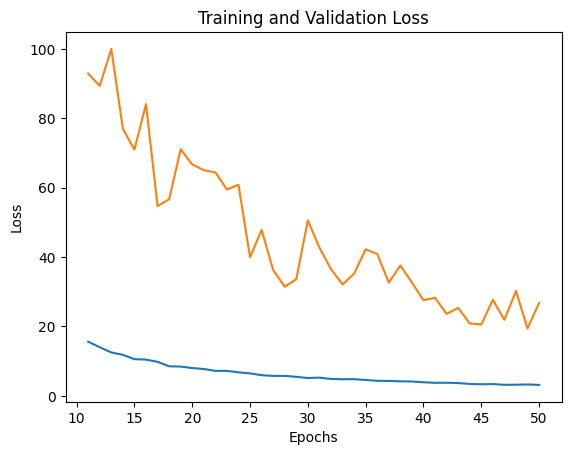

In [41]:
from matplotlib.pylab import plt

epochs = range(11, 51)

plt.plot(epochs, train_loss_list[10:], label='Training Loss')
plt.plot(epochs, eval_loss_list[10:], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [63]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(join("res", file_name[-37:-4] + "_res.svg"), 'w'))
    

In [65]:
names = onlyfiles_pants[:100] + onlyfiles_skirt[:100]

for name in names:
    a = get_data_from_spec(name)
    data = torch.tensor(a[0]).to(torch.float).to(device)
    edge_index = torch.tensor(a[1]).to(device).permute(1,0)
    
    out = model(data, edge_index)
    out = out.tolist()

    out = backto6(name, out, a[2])

    save_res(name,out)

In [62]:
names[1][-37:-4]

'straight_sides_02UKVRO08W_pattern'